The project focusses on finding lane lines to help a car drive by itself. OpenCV functions are used.


## Import Packages
Using matplotlib for visualizing images, OpenCV functions to do opeations on images

In [365]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions
Helper functions to convert images to gray scales, find edges, blur the image, crop the image, find lines in the image

In [366]:
import math

def images_show(input_images, num_cols, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig = plt.figure(figsize=(12, 10), dpi=200)
    for index, image in enumerate(input_images):
        plt.subplot(((len(input_images) + 1) /num_cols), num_cols, index+1)
        plt.imshow(image, cmap=cmap)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

def multiplelines_to_twolines(line_segments):
    """
    From the input of all the 'lines' get the slope and intercept of two lines which we would identify as the lane. 
    We would be taking weighted average of slope and intercept. Bigger lines get more weights. 
    This helps in cancelling out the noise.
    Note1: One line will have positive slope and the other will have negative slope. Origin in images is upper left corner.
    Note2: The weights is length ^ 2. This give much more weigtage to the lines have larger lengths
    """
    line1 = [] #slope (m), intercept (c) 
    line1_length = []
    line2 = []
    line2_length = []
    
    for index, line_segment in enumerate(line_segments):
        for x1, y1, x2, y2 in line_segment:
            #Handle infinite slow when x2=x1 (We can handle it this way ot by converting to polar coordinates)
            if x2 != x1:
                slope = (y2 - y1)/(x2 - x1)
                intercept = y2 - slope * x2
                length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                if(slope > 0):
                    line1.append((slope, intercept))
                    line1_length.append(length ** 2)
                else:
                    line2.append((slope, intercept))
                    line2_length.append(length ** 2)
    
    return np.dot(np.transpose(normalize(line1_length)), line1), np.dot(np.transpose(normalize(line2_length)), line2)
                
    
def drawline_slope_intercept(image, lines):
    "Converts slope and intercept of a line to pixel coordinates of give image_shape (row, cols)"
    if len(lines) == 0:
        return None
    else:
        line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        lines_pixels = []
        for line in np.squeeze(np.asarray(lines)):
            slope = line[0]
            intercept = line[1]
            y1 = int(round(0.60 * image.shape[0]))
            x1 = int(round((y1 - intercept)/slope))
            y2 = image.shape[0]
            x2 = int(round((y2 - intercept)/slope))
            lines_pixels.append([[x1, y1, x2, y2]])
        draw_lines(line_img, lines_pixels)
        return line_img
    

## Load and visualize input images

Read 6 images from test_images/ folder


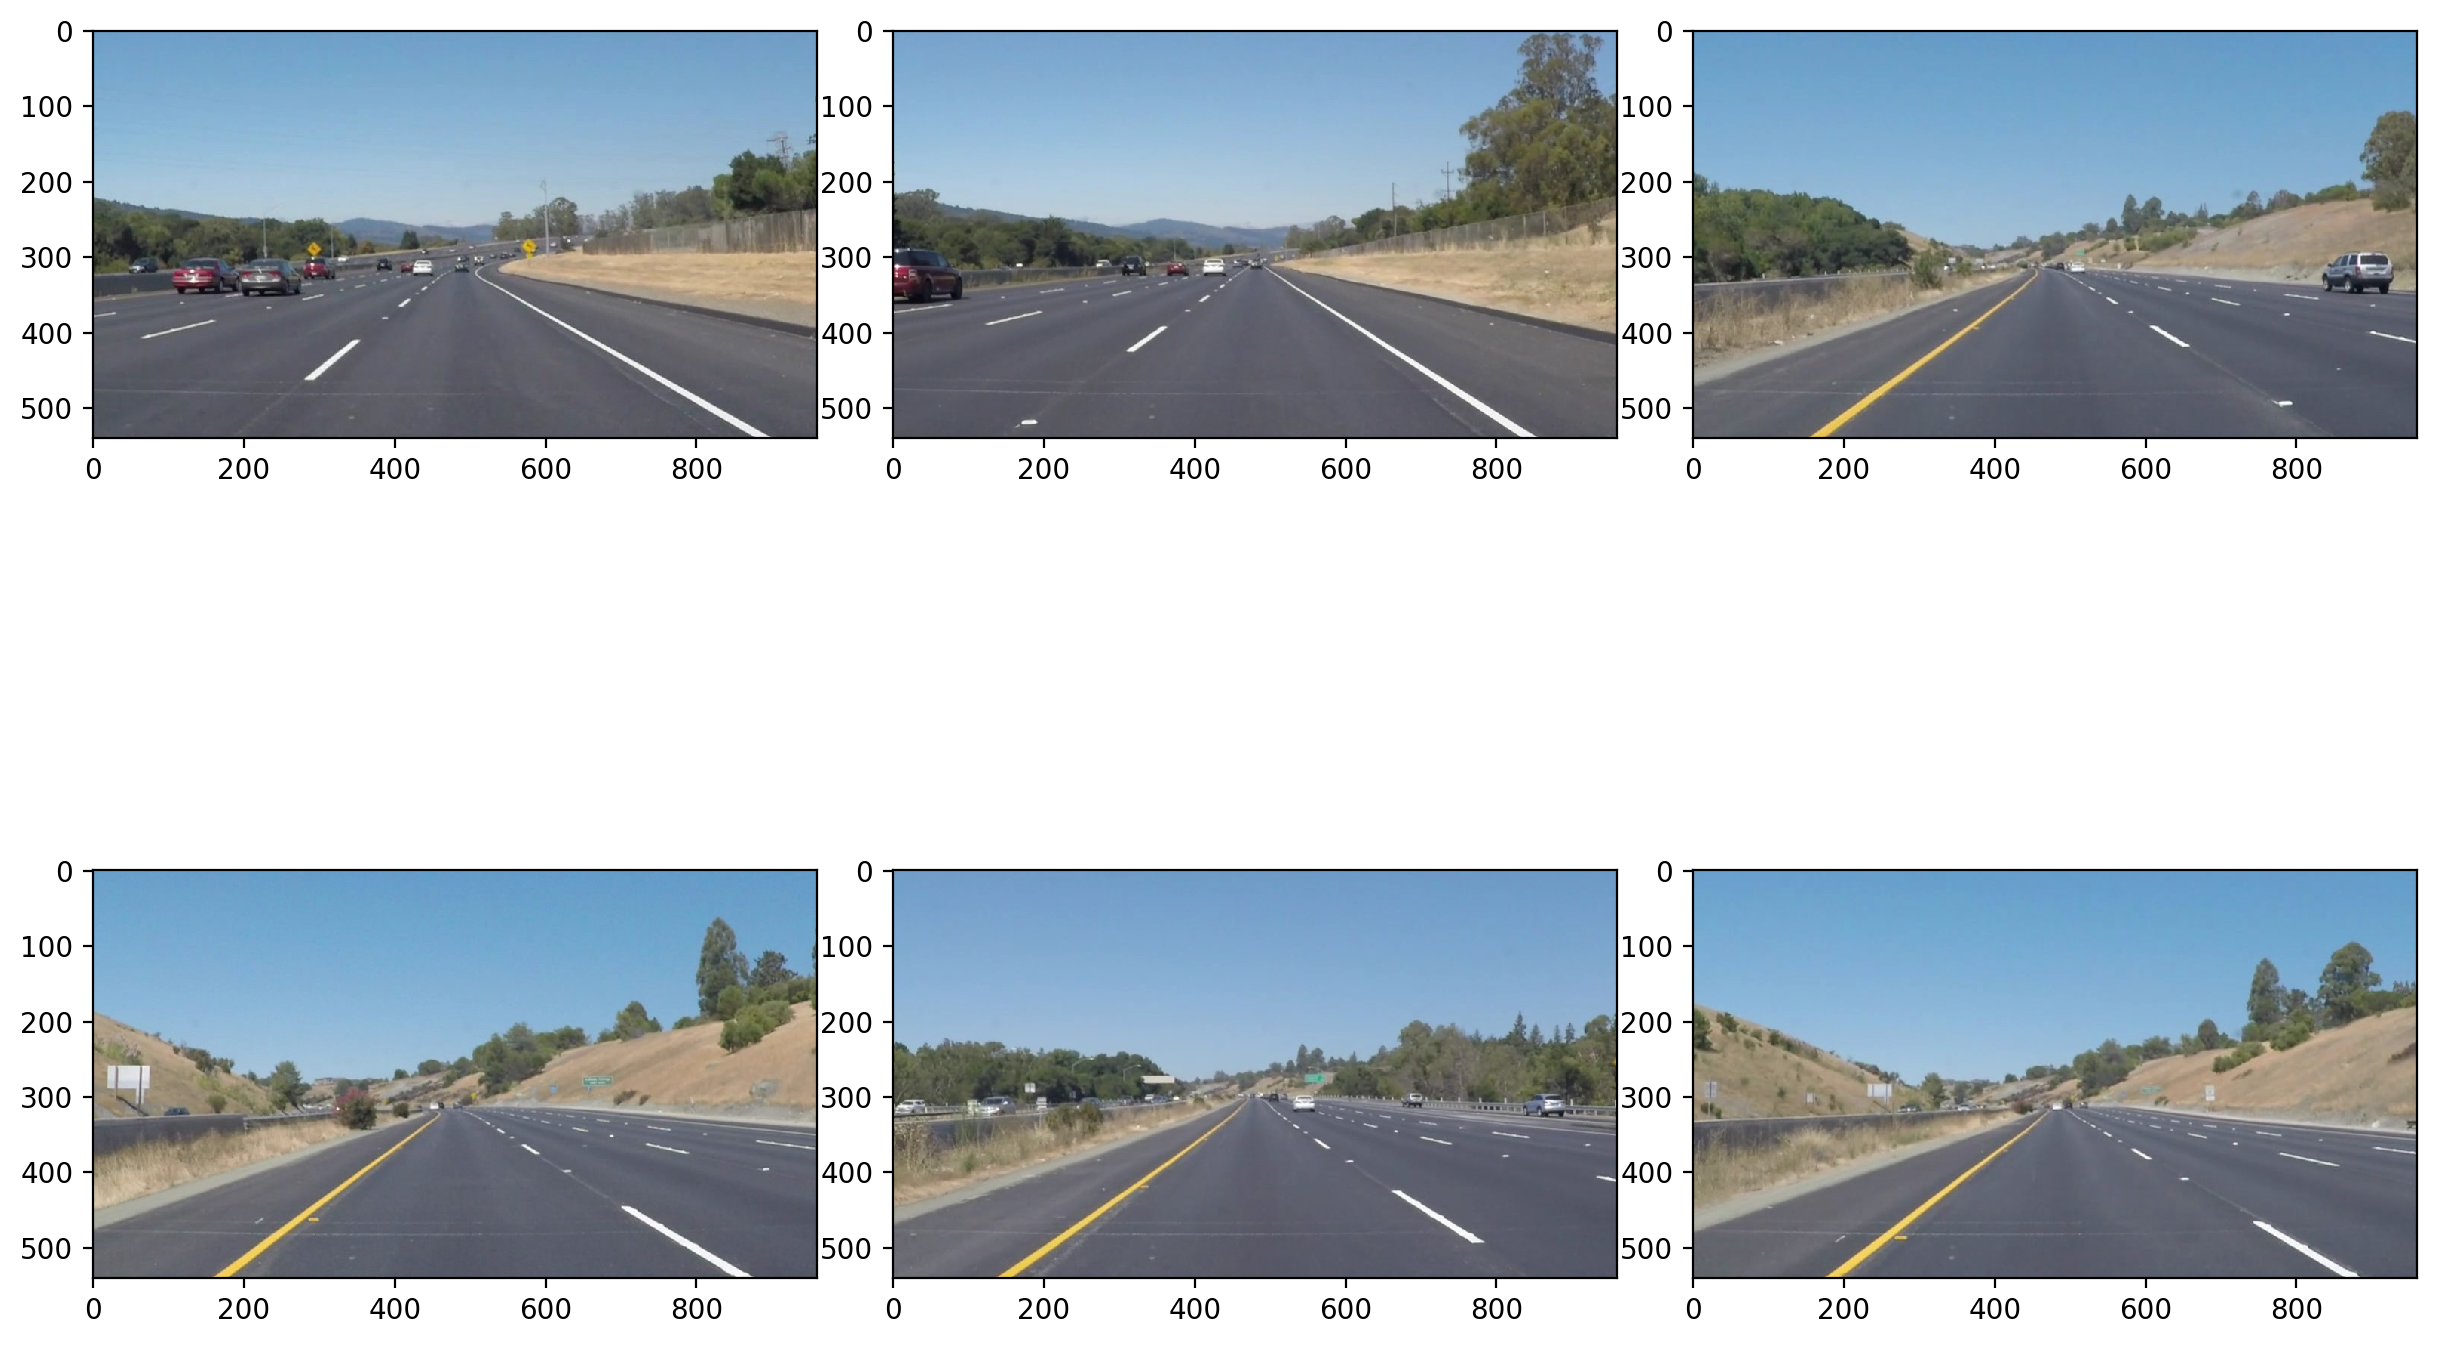

In [367]:
data_path = "test_images/"
input_images = [mpimg.imread(data_path + image_name) for image_name in os.listdir("test_images/")]

print("Read %d images from %s folder" % (len(input_images), data_path))
images_show(input_images, 3)

## Find Lanes
#### Step 1: Convert images to gray scale
Notice in the resultant images we can clearly see the lines are more whitish in color, road is blackish, ** side of the road is grayish in color which potentially can mess up with our results**

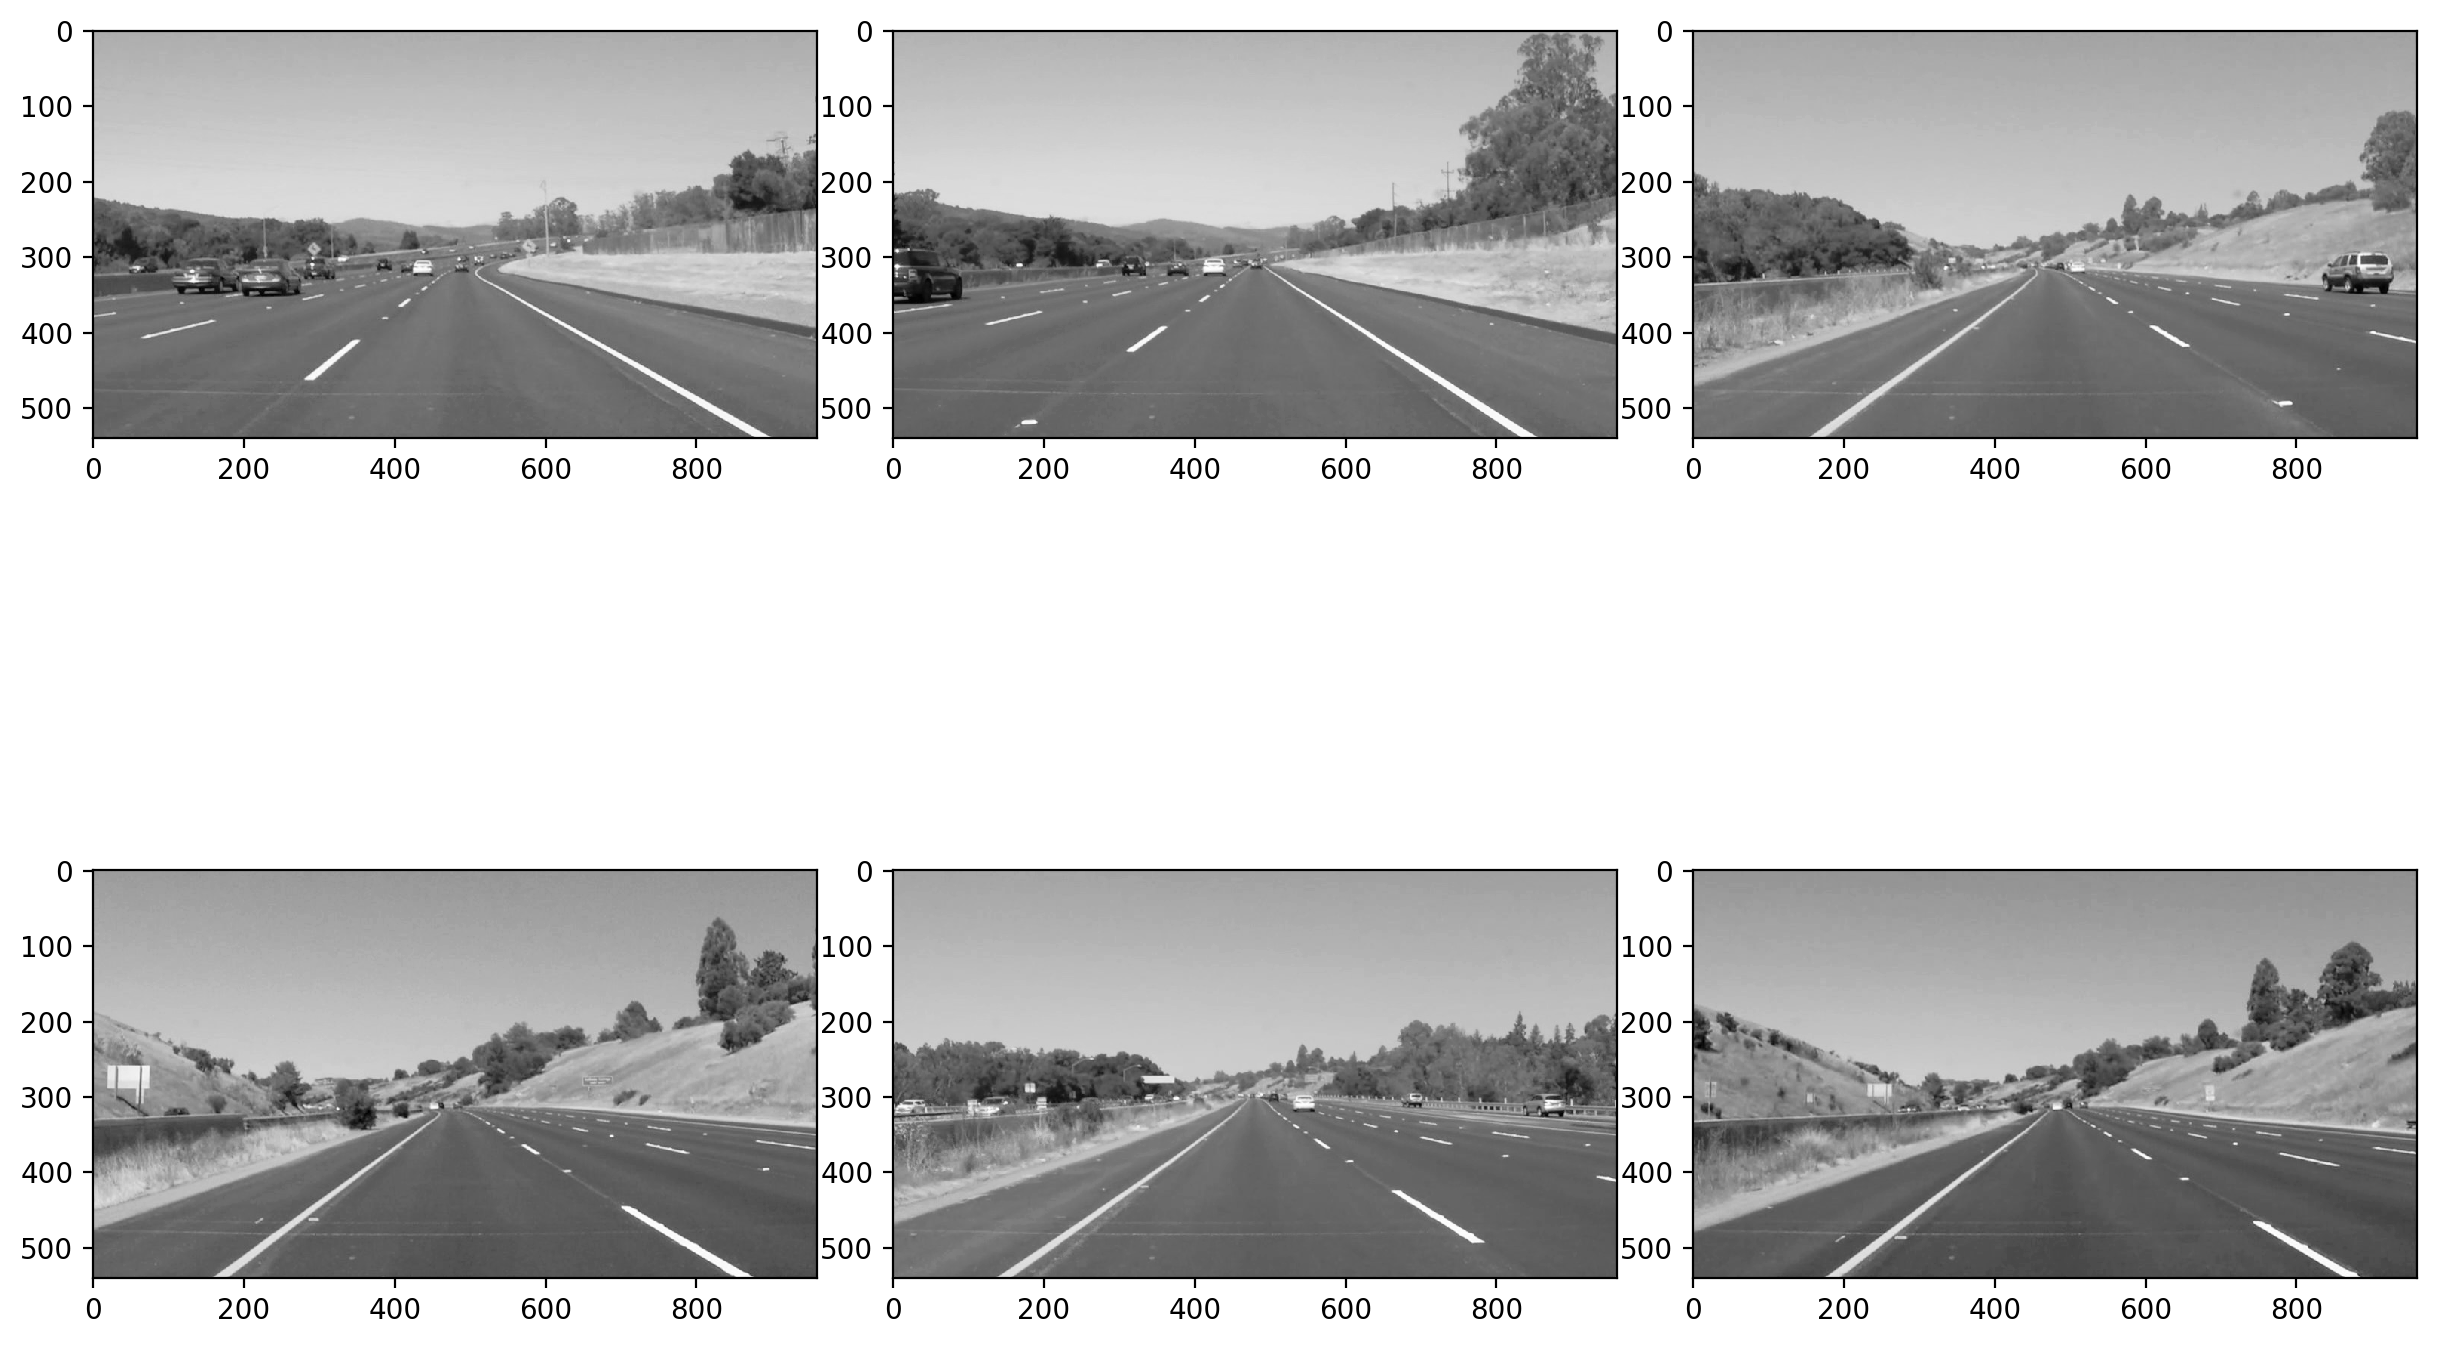

In [368]:
gray_images = [grayscale(image) for image in input_images]
images_show(gray_images, 3, cmap='Greys_r')

#### Step 2: Define kernel size and blur images using gaussian kernel

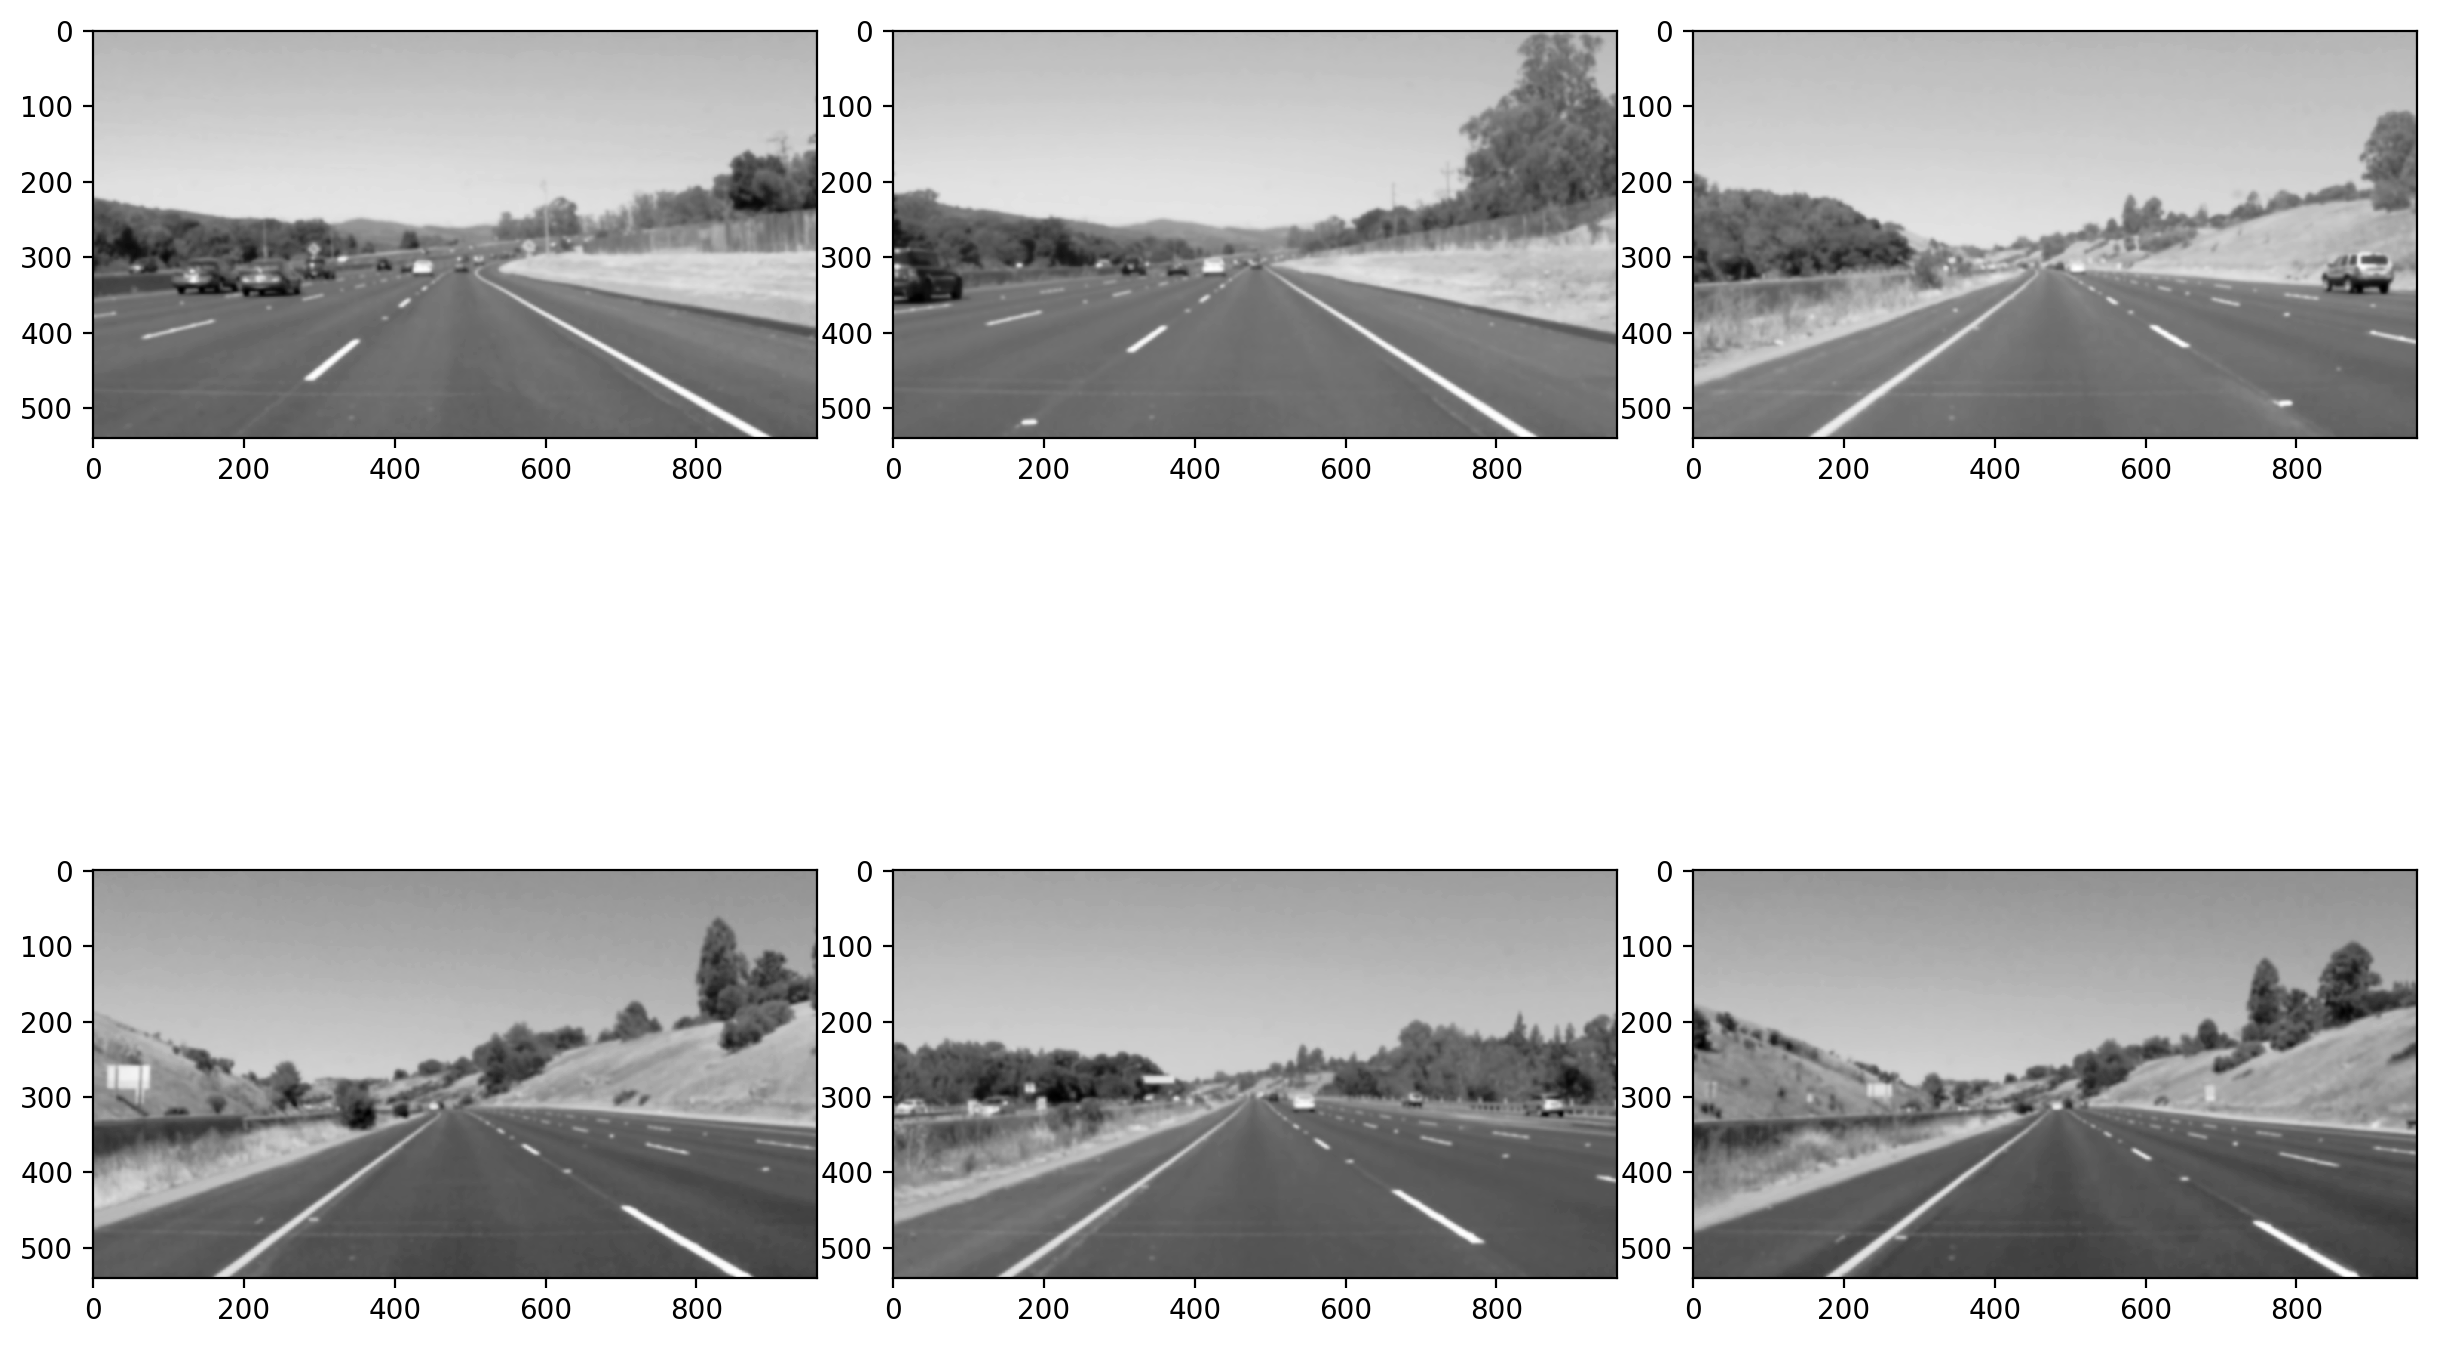

In [369]:
kernelSize = 11
blurred_images = [gaussian_blur(image, kernelSize) for image in gray_images]
images_show(blurred_images, 3, cmap='Greys_r')

#### Step 3: Detect edges using canny edge detector function of OpenCV
Note 1: output of canny is the binary image

**Note 2: Canny function can take in the gaussian kernel. it is better to pass it to that rather than applying gaussian in the previous step. This is because the operations are assosiative and taking derivate on the kernel is much faster (kernel size is very small as compared to image) and in videos the derivate of kernels is taken only once as compared to taking the derivate of each frame**

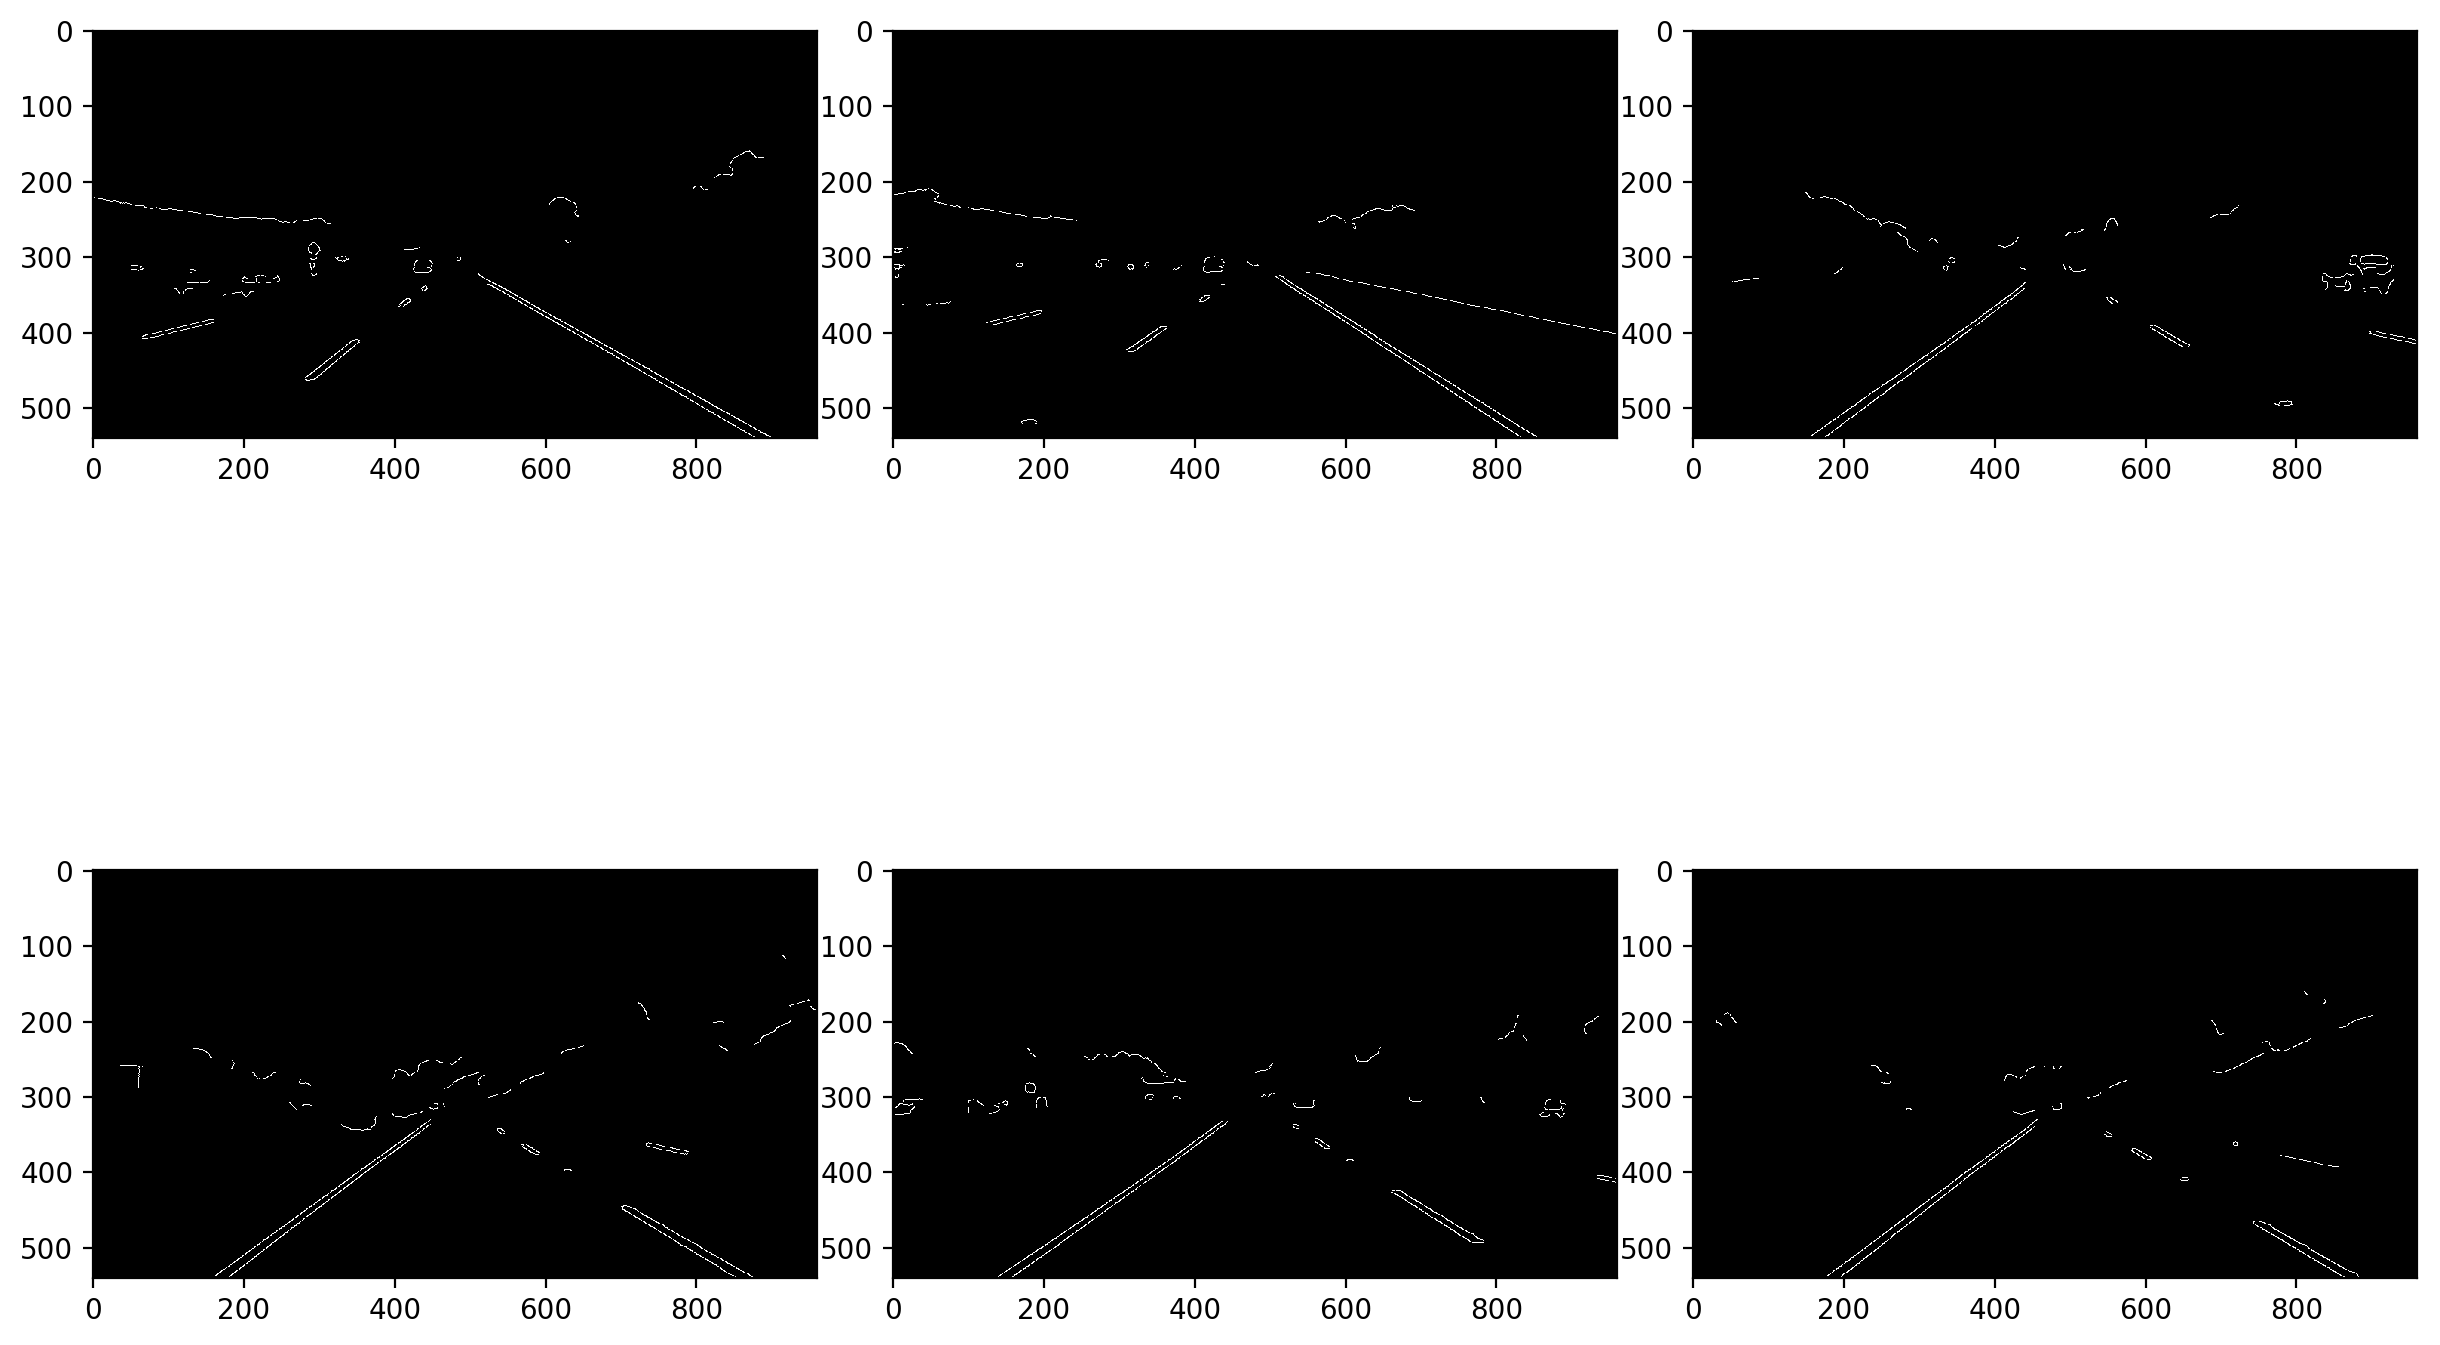

In [370]:
low_threshold = 100
high_threshold = 150
edges_in_images = [canny(image, low_threshold, high_threshold) for image in blurred_images]
images_show(edges_in_images, 3, cmap='Greys_r')

#### Step 4: Define the points for region of interest and Mask the image with the polygon generated from the points

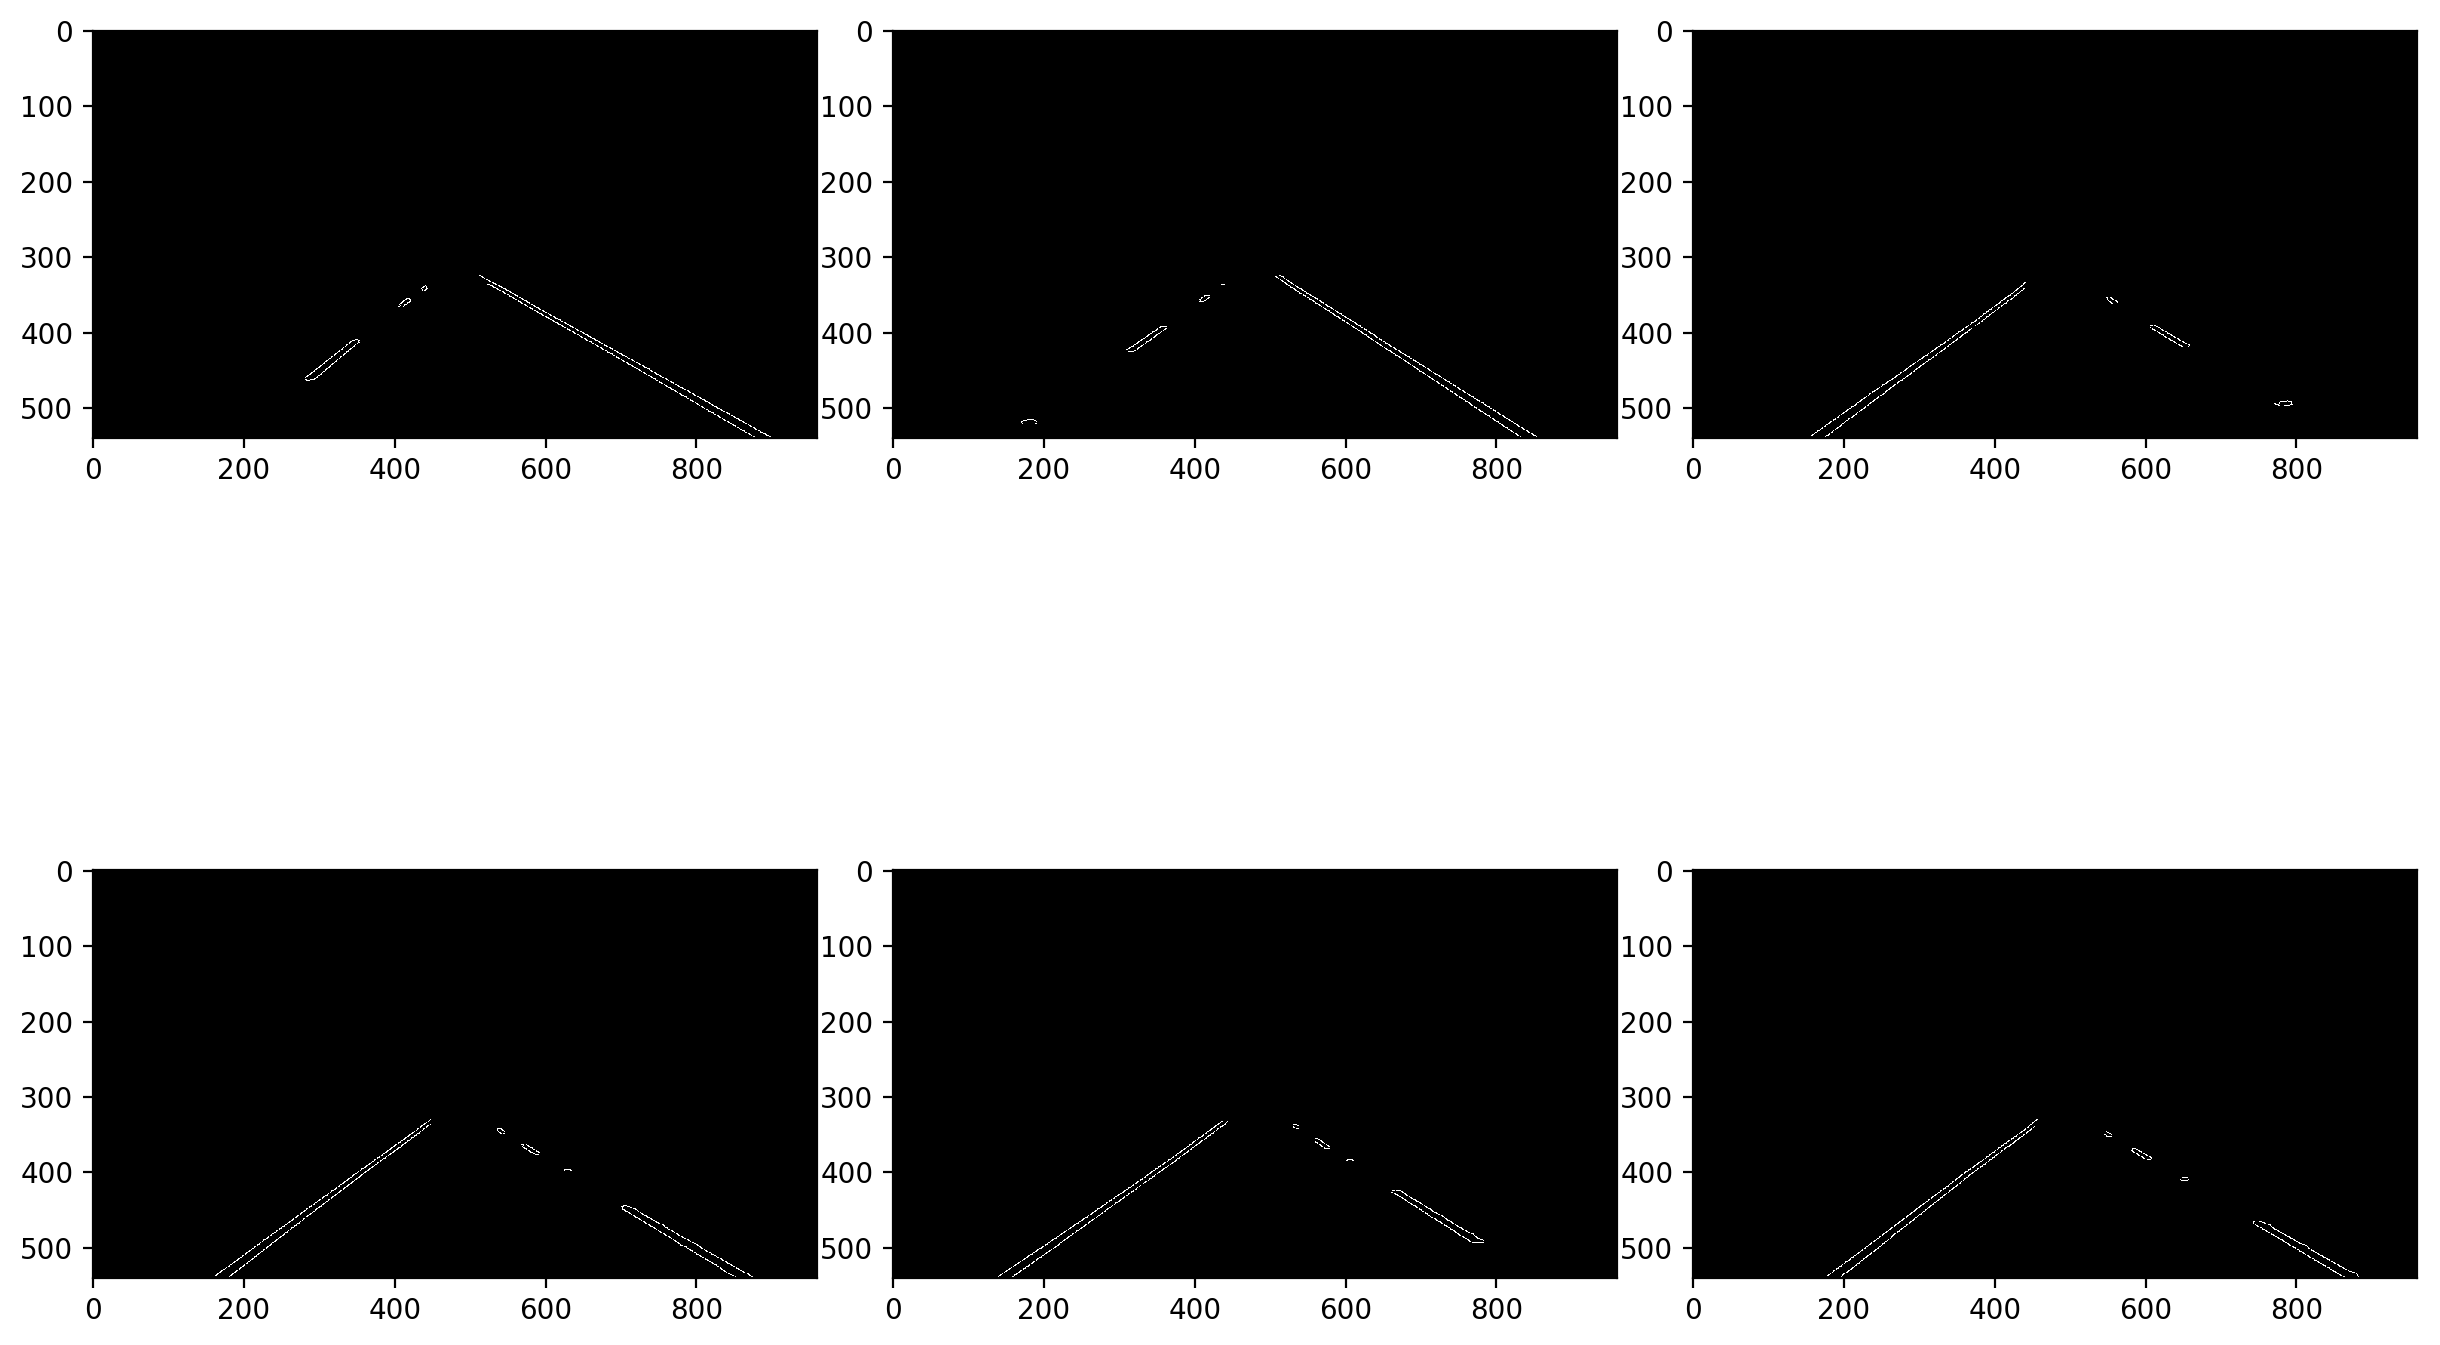

In [371]:
masked_images = []
for edges in edges_in_images:
    imshape = edges.shape
    vertices = np.array([(0 ,imshape[0]), (imshape[1], imshape[0]), (imshape[1] * 0.55, imshape[0] * 0.6),(imshape[1] * 0.45, imshape[0] * 0.6)], dtype=np.int32)
    masked_images.append(region_of_interest(edges, [vertices]))
    
#     lines = [np.array([np.array([vertices[len(vertices) - index - 1][0]]), np.array([vertices[len(vertices) - index - 1][1]]), \
#             np.array([vertices[len(vertices) - index - 2][0]]), np.array([vertices[len(vertices) - index - 2][1]])]) for index in range(len(vertices))]
#     for line in lines:
#         for x1, y1, z1, r1 in list(line): 
#             print("Test")
#    draw_lines(masked_images, lines);
images_show(masked_images, 3, cmap='Greys_r')

#### Step 5: Define Hough transform params and apply hough transform to get the lines

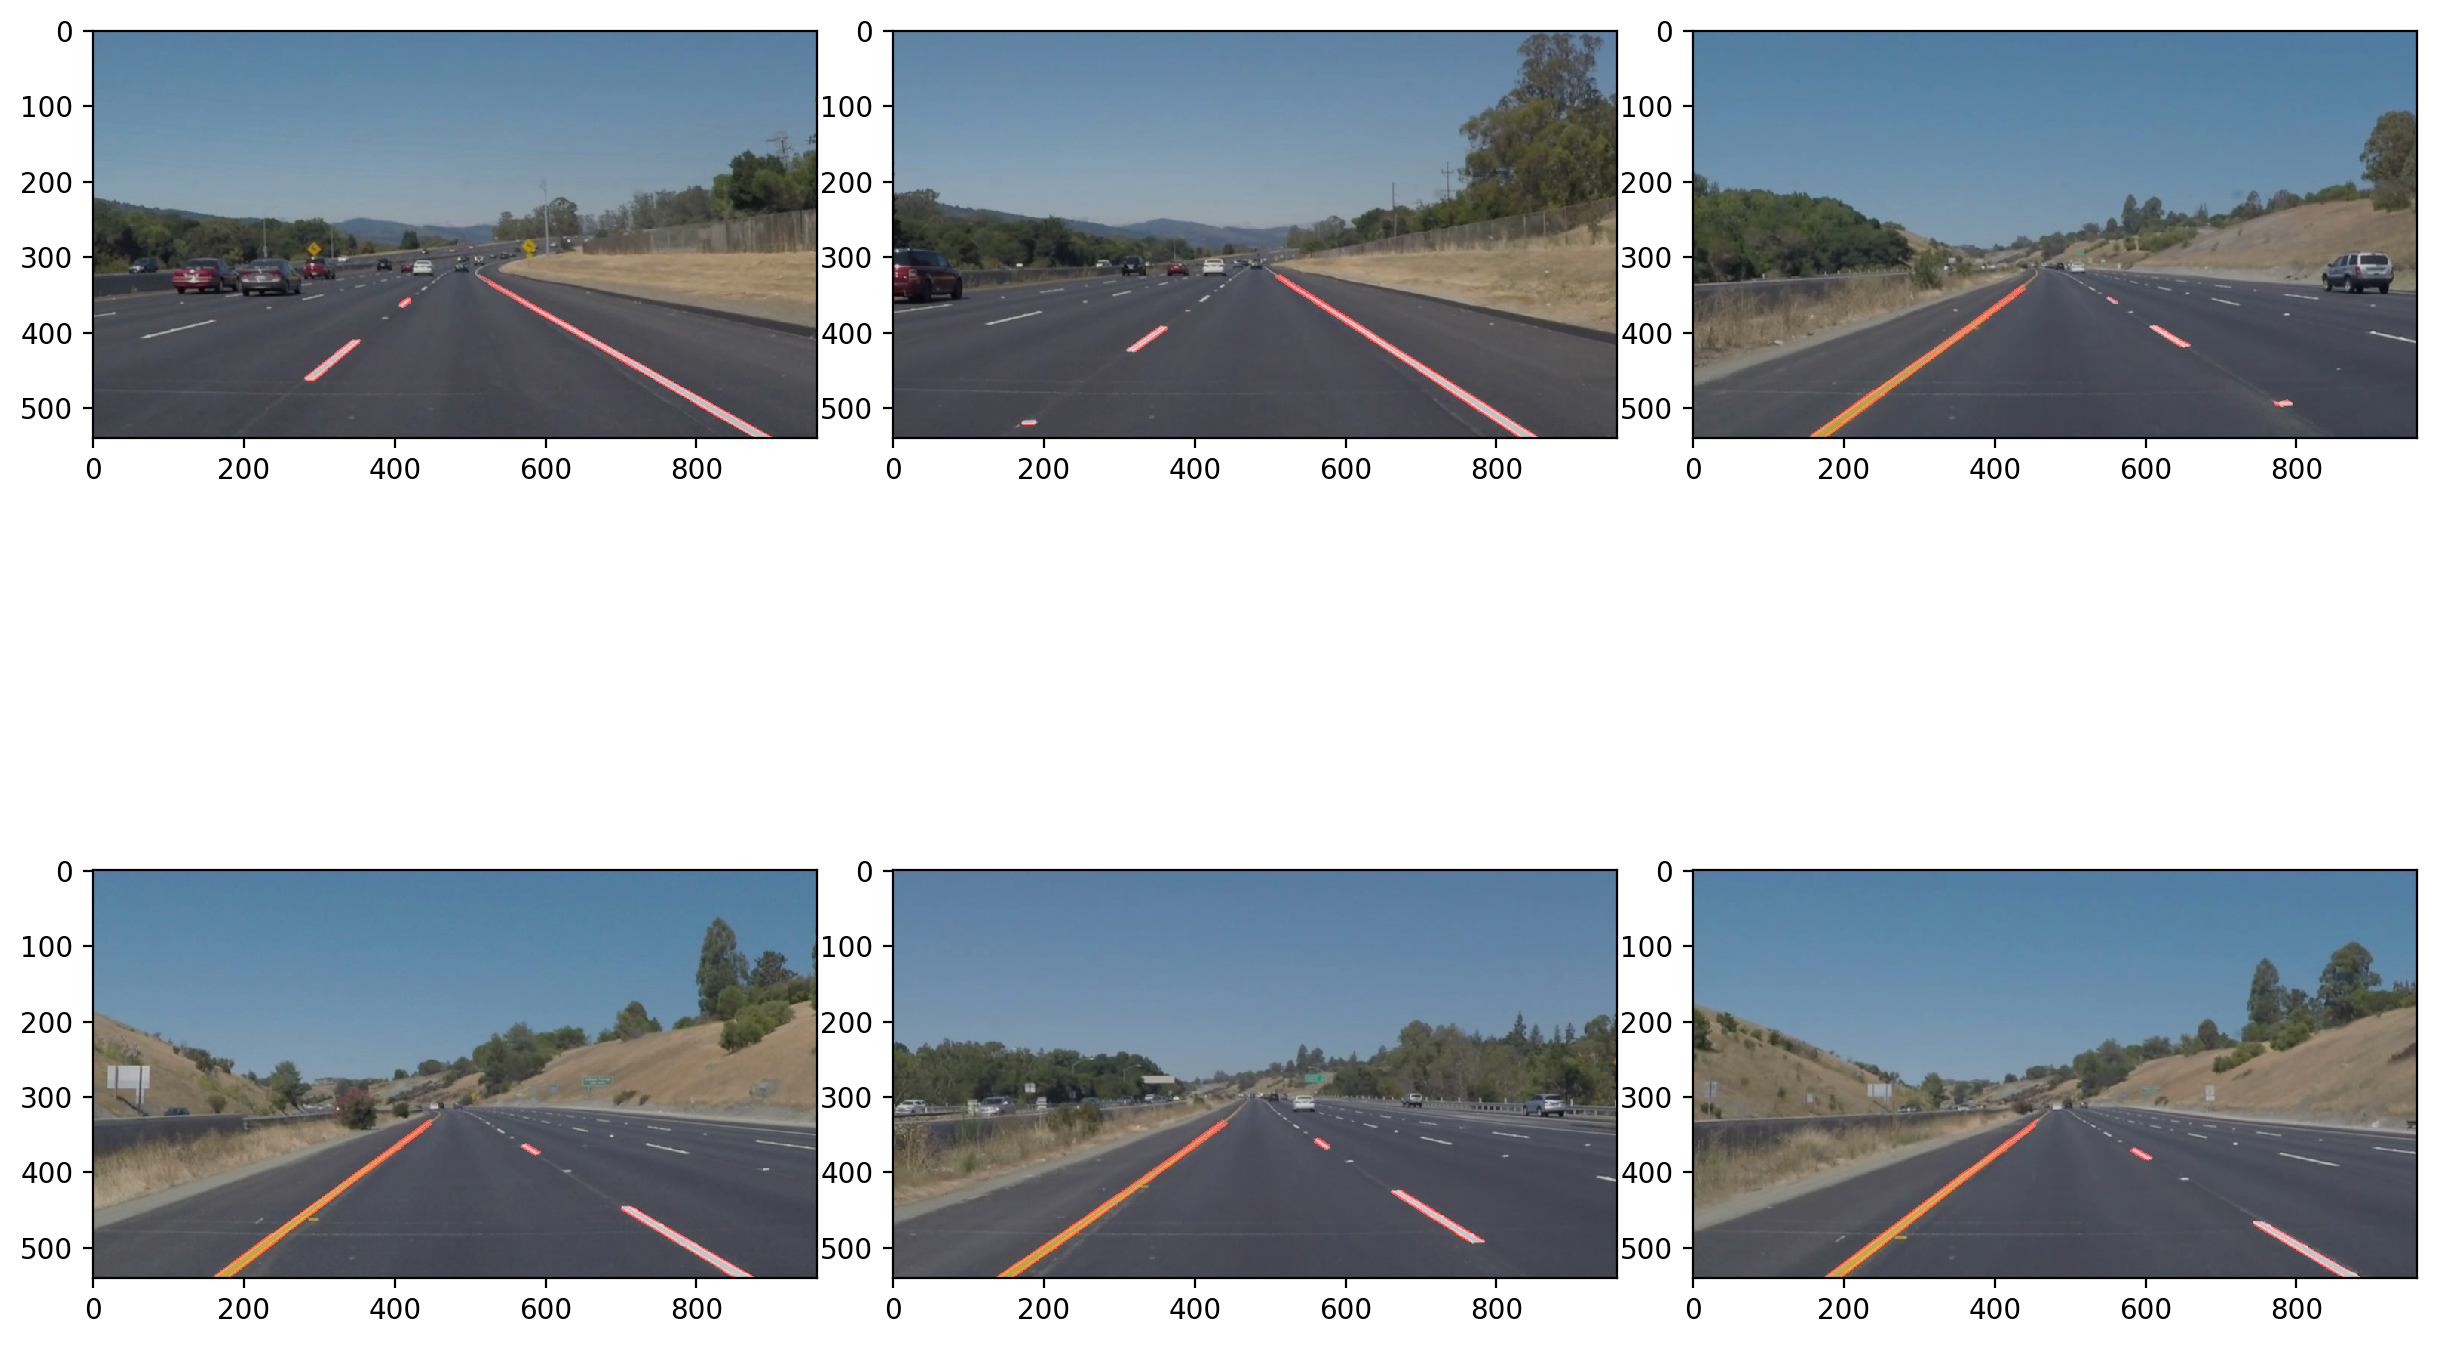

In [372]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

lines_and_images  = [hough_lines(image, rho, theta, threshold, min_line_length, max_line_gap) for image in masked_images]
hough_images = [weighted_img(lines_and_images[index][1], input_images[index]) for index in range(len(lines_and_images))]

images_show(hough_images, 3)

#### Step 6: Get two line from the list of lines by the output of hough transform

In [373]:
two_lines_images = [multiplelines_to_twolines(lines_in_image) for lines_in_image, image in lines_and_images]

#### Step 7: Get pixels of two lines

In [374]:
result_lines = [drawline_slope_intercept(input_images[index], two_lines_images[index]) for index in range(len(input_images))]

#### Step 8: Get the final image with 2 lines 

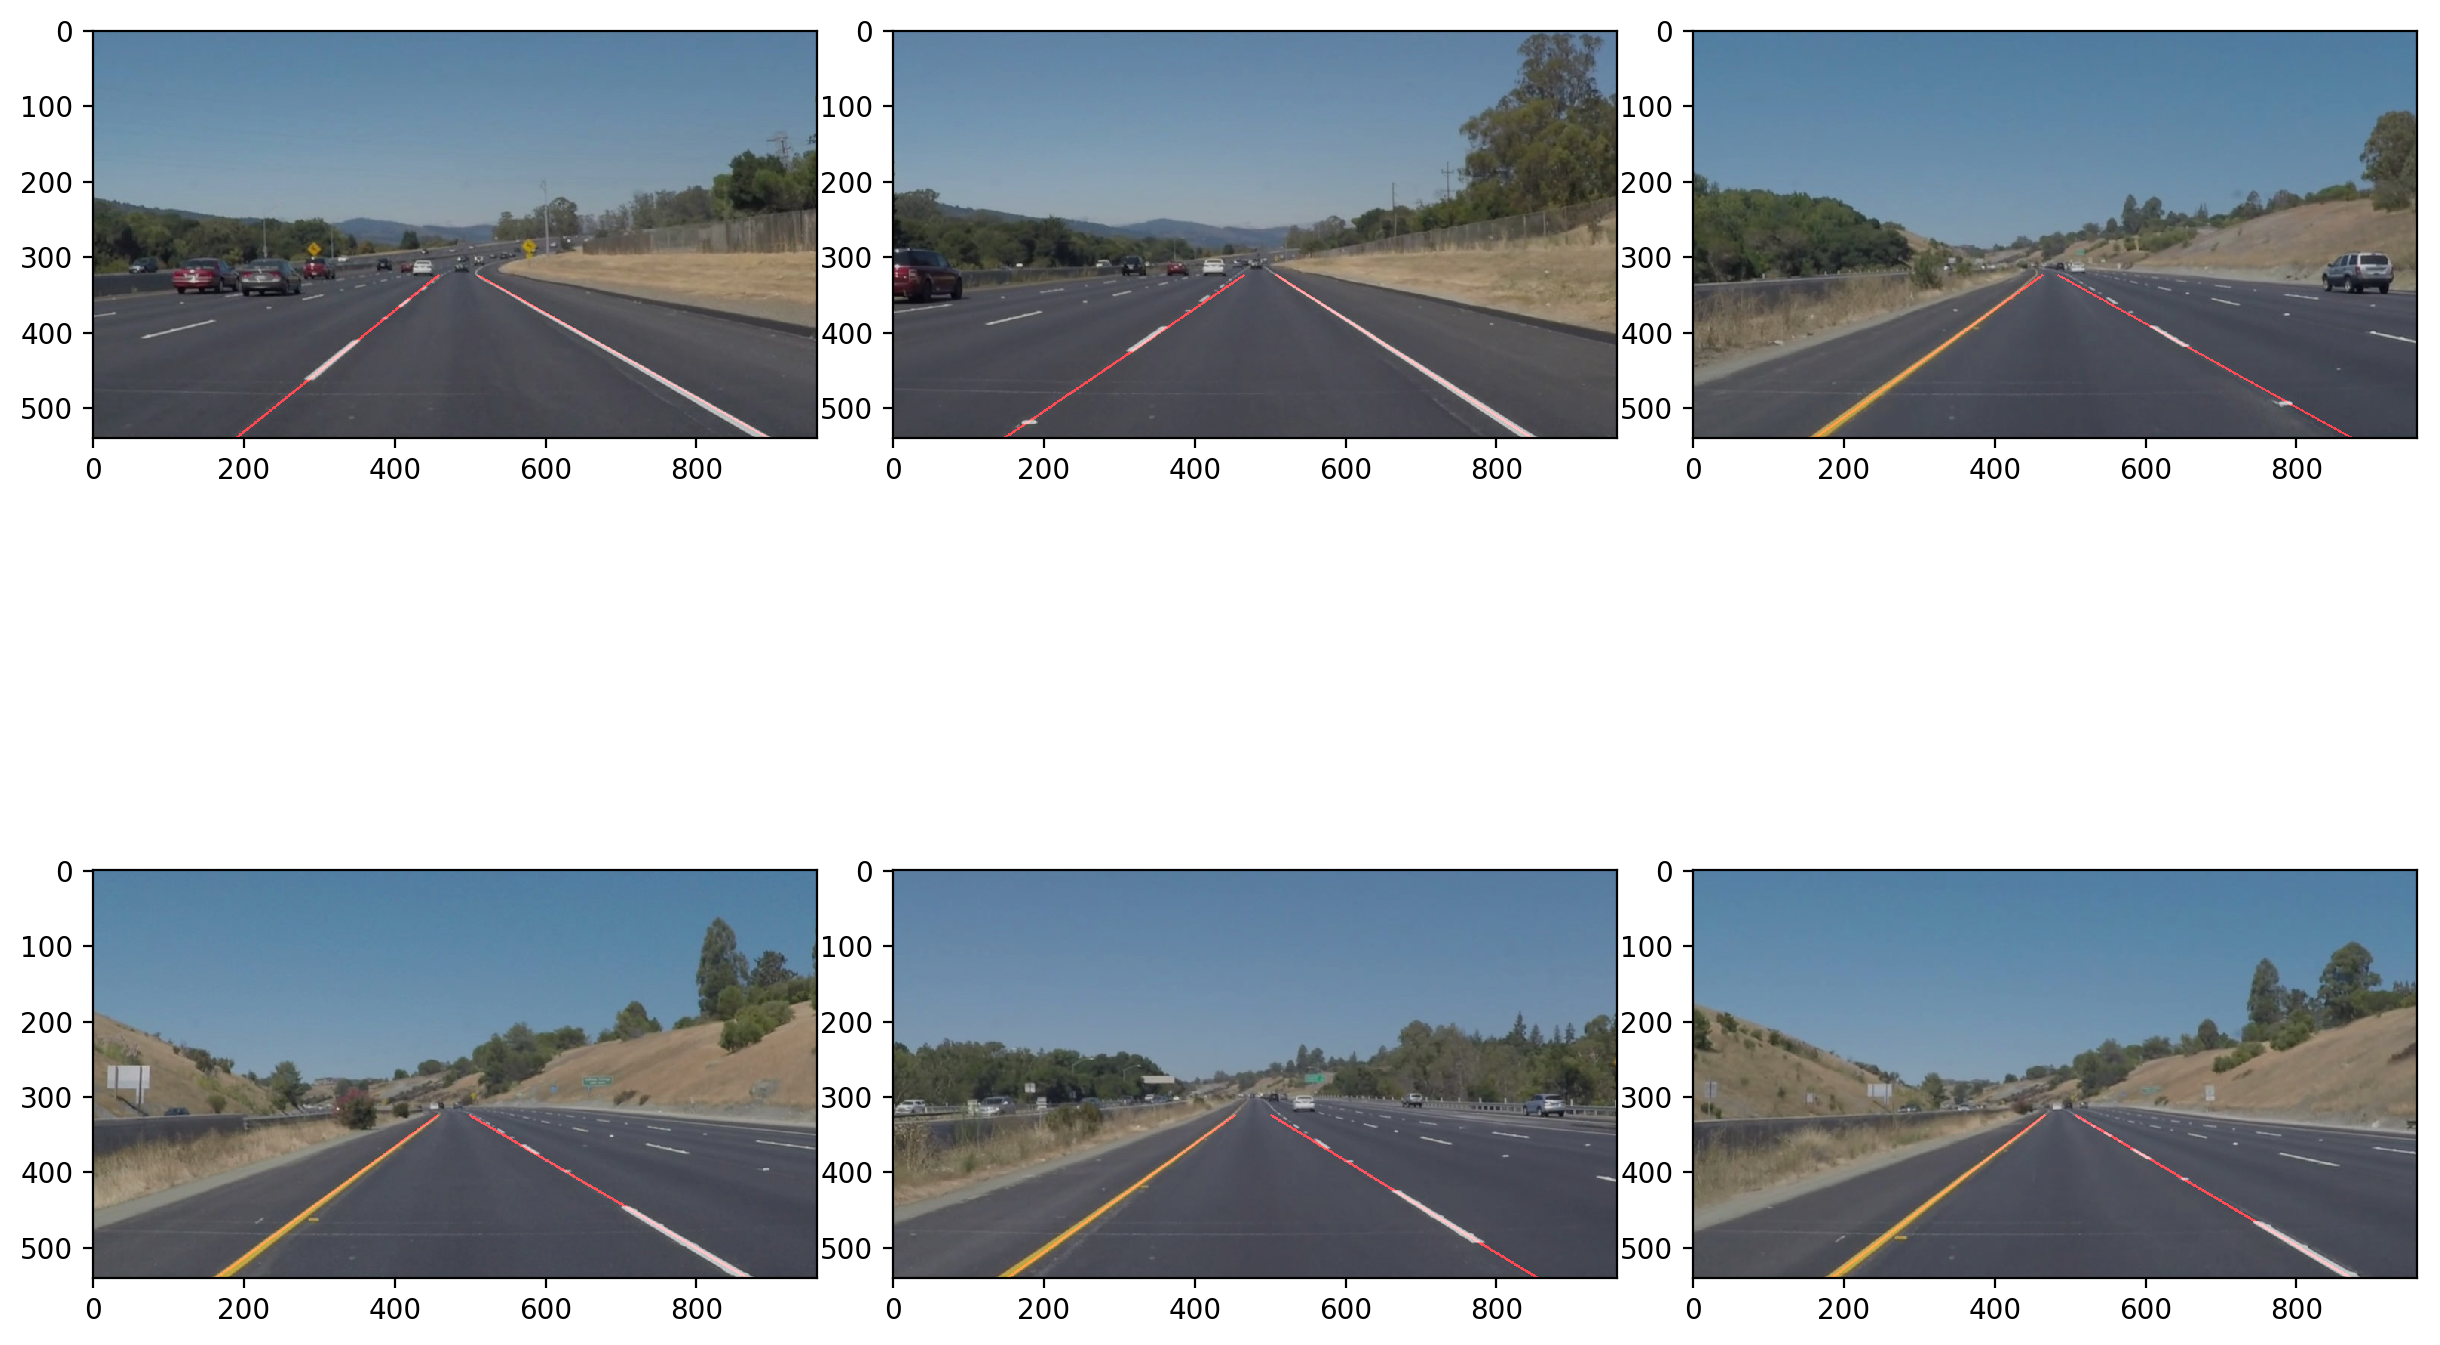

In [375]:
result_images = [weighted_img(result_lines[index], input_images[index]) for index in range(len(result_lines))]
images_show(result_images, 3)

# Videos

In [376]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [377]:
def process_image(image):
    imshape = image.shape
    vertices = np.array([(0 ,imshape[0]), (imshape[1], imshape[0]), (imshape[1] * 0.55, imshape[0] * 0.6),(imshape[1] * 0.45, imshape[0] * 0.6)], dtype=np.int32)
    grayImage = grayscale(image)
    blurredImage = gaussian_blur(grayImage, kernelSize)
    edges = canny(blurredImage, low_threshold, high_threshold)
    masked_image = region_of_interest(edges, [vertices])
    lines, image_lines = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    two_lines = multiplelines_to_twolines(lines)
    result_lines = drawline_slope_intercept(image, two_lines)
    result = weighted_img(result_lines, image)
    
    return result

In [378]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 8.55 s, sys: 316 ms, total: 8.86 s
Wall time: 6.46 s


In [379]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [380]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 47.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 26 s, sys: 812 ms, total: 26.8 s
Wall time: 14.8 s


In [360]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [361]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:11<00:00, 21.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.1 s, sys: 436 ms, total: 12.5 s
Wall time: 12.5 s


In [362]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))